In [1]:
import numpy as np
from scipy.stats import norm, uniform, gaussian_kde, multivariate_normal
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import wooldridge
from numba import njit
import seaborn as sns
from see import see

In [2]:
wage1 = wooldridge.data('wage1').loc[:,['wage', 'educ', 'tenure', 'exper']]

In [3]:
wooldridge.data('wage1',description=True)

name of dataset: wage1
no of variables: 24
no of observations: 526

+----------+---------------------------------+
| variable | label                           |
+----------+---------------------------------+
| wage     | average hourly earnings         |
| educ     | years of education              |
| exper    | years potential experience      |
| tenure   | years with current employer     |
| nonwhite | =1 if nonwhite                  |
| female   | =1 if female                    |
| married  | =1 if married                   |
| numdep   | number of dependents            |
| smsa     | =1 if live in SMSA              |
| northcen | =1 if live in north central U.S |
| south    | =1 if live in southern region   |
| west     | =1 if live in western region    |
| construc | =1 if work in construc. indus.  |
| ndurman  | =1 if in nondur. manuf. indus.  |
| trcommpu | =1 if in trans, commun, pub ut  |
| trade    | =1 if in wholesale or retail    |
| services | =1 if in services indus.  

In [4]:
wage1['wage_log'] = np.log(wage1['wage'])

In [5]:
formula_1 = 'wage_log ~ educ + tenure + exper'

In [6]:
res_1 = ols(formula_1, data=wage1).fit()

In [7]:
see(res_1)

    <                    <=                   ==                   !=
    >                    >=                   dir()                hash()
    help()               repr()               str()                .HC0_se
    .HC1_se              .HC2_se              .HC3_se              .aic
    .bic                 .bse                 .centered_tss
    .compare_f_test()    .compare_lm_test()
    .compare_lr_test()                        .condition_number    .conf_int()
    .conf_int_el()       .cov_HC0             .cov_HC1             .cov_HC2
    .cov_HC3             .cov_kwds            .cov_params()        .cov_type
    .df_model            .df_resid            .eigenvals           .el_test()
    .ess                 .f_pvalue            .f_test()
    .fittedvalues        .fvalue              .get_influence()
    .get_prediction()    .get_robustcov_results()
    .initialize()        .k_constant          .llf                 .load()
    .model               .mse_model           .mse_

In [8]:
res_1.params

Intercept    0.284360
educ         0.092029
tenure       0.022067
exper        0.004121
dtype: float64

In [9]:
res_1.params[1]

0.09202898676928312

In [10]:
wm = wage1.mean()  # 変数の平均の計算
wm

wage         5.896103
educ        12.562738
tenure       5.104563
exper       17.017110
wage_log     1.623268
dtype: float64

In [11]:
wm['educ']

12.562737642585551

In [12]:
z = pd.DataFrame({'educ':[wm['educ']],
                  'tenure':[wm['tenure']],
                  'exper':[wm['exper']]})

In [13]:
res_1.predict(z)

0    1.623268
dtype: float64

In [14]:
educ_mean = wm['educ']
tenure_mean = wm['tenure']
exper_mean = wm['exper']

z2 = pd.DataFrame({'educ':[educ_mean*0.5, educ_mean, educ_mean*1.5],
                  'tenure':[tenure_mean]*3,
                  'exper':[exper_mean]*3})
res_1.predict(z2)

0    1.045200
1    1.623268
2    2.201336
dtype: float64

In [15]:
( res_1.predict() == res_1.fittedvalues ).all()

True

In [16]:
formula_2 = 'np.log(wage) ~ educ + tenure + exper'

In [17]:
res_2 = ols(formula_2, data=wage1).fit()

In [18]:
res_2.params

Intercept    0.284360
educ         0.092029
tenure       0.022067
exper        0.004121
dtype: float64

In [19]:
formula_3 = 'np.log(wage) ~ educ + tenure + exper + I(exper**2)'
res_3 = ols(formula_3, data=wage1).fit()

In [20]:
res_3.params

Intercept        0.198345
educ             0.085349
tenure           0.020841
exper            0.032854
I(exper ** 2)   -0.000661
dtype: float64

In [21]:
def myfunc(x):
    return x**2

In [22]:
formula_4 = 'np.log(wage) ~ educ + exper + tenure + myfunc(exper)'
res_4 = ols(formula_4, data=wage1).fit()

In [23]:
res_4.params

Intercept        0.198345
educ             0.085349
exper            0.032854
tenure           0.020841
myfunc(exper)   -0.000661
dtype: float64

In [24]:
formula_1a = 'wage ~ educ + tenure + exper'
res_1a = ols(formula_1a, data=wage1).fit()
res_1a.params

Intercept   -2.872735
educ         0.598965
tenure       0.169269
exper        0.022340
dtype: float64

In [25]:
res_1.scale

0.19435933207482123

In [26]:
SSR = res_1.ssr  # 残差の二乗平方和
n = res_1.nobs
k = res_1.df_model
SSR/(n-k-1)

0.19435933207482123

In [27]:
res_1.bse

Intercept    0.104190
educ         0.007330
tenure       0.003094
exper        0.001723
dtype: float64

In [28]:
b0 = 1  # 定数項
b1 = 2  # x1の係数
b2 = 3  # x2の係数
n = 30  # 標本の大きさ

In [29]:
x1 = np.random.normal(loc=4.0, scale=2.0, size=n)  # (1)の説明

x2 = np.random.uniform(low=1.0, high= 10.0, size=n)  # (2)の説明

u = np.random.normal(loc=0, scale=1.0, size=n)  # (1)の説明

y = b0 + b1*x1 + b2*x2 + u

c = np.ones(n)  # (3)の説明

In [30]:
X = np.stack([c,x1,x2],axis=1)
X.shape

(30, 3)

In [31]:
bhat = np.linalg.inv((X.T)@X)@(X.T)@y
bhat

array([1.20998481, 1.97910608, 3.00770789])

In [32]:
df_check = pd.DataFrame({'Y':y,'X1':x1,'X2':x2})
ols('Y ~ X1 + X2', data=df_check).fit().params

Intercept    1.209985
X1           1.979106
X2           3.007708
dtype: float64

In [33]:
@njit  # 計算の高速化
def sim_unbias(n, N, b0=1.0, b1=2.0, b2=3.0):

    # N個の0からなるarrayであり、0を推定値と置き換えて格納する
    b0hat_arr = np.zeros(N)
    b1hat_arr = np.zeros(N)
    b2hat_arr = np.zeros(N)
    
    c = np.ones(n)  # 定数項
    
    for i in range(N):  # N 回のループ
        
        # 標準正規分布
        u = np.random.normal(loc=0, scale=1.0, size=n)
        
        # 平均4.0,標準偏差2.0の正規分布
        x1 = np.random.normal(loc=4, scale=2.0, size=n)
        
        # [1,10)の一様分布。`low=`，`high=`を付け加えるとエラーが発生する。
        x2= np.random.uniform(1.0, 10.0, size=n)
        
        y = b0 + b1*x1 + b2*x2 + u  # 被説明変数の生成
        
        X = np.stack((c,x1,x2),axis=1)  # 説明変数の行列
        bhat = np.linalg.inv((X.T)@X)@(X.T)@y  # OLS推定
        
        b0hat_arr[i] = bhat[0]  # 上のarrayに推定値を代入する
        b1hat_arr[i] = bhat[1]
        b2hat_arr[i] = bhat[2]
        
    return b0hat_arr, b1hat_arr, b2hat_arr

In [34]:
b0hat, b1hat, b2hat = sim_unbias(n=30, N=100_000)

In [35]:
print('b0:', b0hat.mean(),
      '\nb1:', b1hat.mean(),
      '\nb1:', b2hat.mean())

b0: 0.9975400167673023 
b1: 2.0002132457296944 
b1: 3.0004161047169338


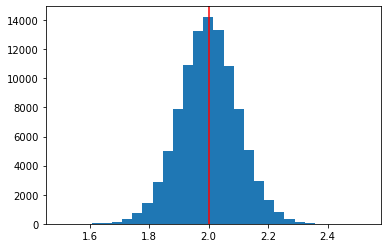

In [36]:
plt.hist(b1hat,bins=30)
plt.axvline(x=b1,color='red')
pass

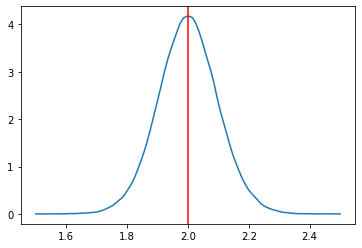

In [37]:
x=np.linspace(1.5,2.5,100)  # 図を作成するために1.5から2.5までの横軸の値を設定
kde_model=gaussian_kde(b1hat)  # カーネル密度推定を使いb1hatの分布を推定

plt.plot(x, kde_model(x))  # 誤差項の分布をプロット
plt.axvline(x=b1,color='red')  # 母集団のパラメータ
pass

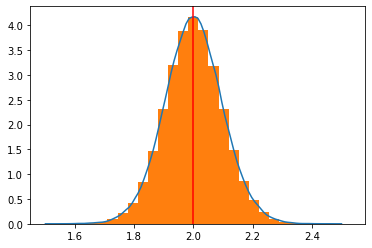

In [38]:
x=np.linspace(1.5,2.5,100)
kde_model=gaussian_kde(b1hat)

plt.plot(x, kde_model(x))
plt.hist(b1hat,bins=30, density=True)
plt.axvline(x=b1,color='red')
pass

In [39]:
wage1_vif = wage1.drop('wage', axis=1)

In [40]:
mc = wage1_vif.corr().to_numpy()

In [41]:
vif_manual = np.linalg.inv(mc).diagonal()
vif_manual

array([1.44880661, 1.4808149 , 1.49380638, 1.46201677])

In [42]:
pd.Series(vif_manual, index=wage1_vif.columns)

educ        1.448807
tenure      1.480815
exper       1.493806
wage_log    1.462017
dtype: float64

In [43]:
def my_vif(dataframe):
    mc = dataframe.corr().to_numpy()
    vif = np.linalg.inv(mc).diagonal()
    return pd.Series(vif_manual, index=dataframe.columns)

my_vif(wage1_vif)

educ        1.448807
tenure      1.480815
exper       1.493806
wage_log    1.462017
dtype: float64

In [44]:
wage1_vif['Intercept'] = 1.0

In [45]:
for i in range(len(wage1_vif.columns)-1):  # 定数項は無視するために-1
    name = wage1_vif.columns[i]
    vif_val = vif(wage1_vif.to_numpy(), i)
    print(f'{name : <10}{vif_val: >10}')

educ      1.4488066076300705
tenure    1.4808148965681553
exper     1.4938063815278086
wage_log  1.4620167739746217


In [46]:
def sim_multi(n, N, m, b0=1.0, b1=2.0, b2=3.0):  # n=標本の大きさ, N=標本数, m=共分散
    
    # ２つのx1,x2の共分散を設定
    rv_mean = [4, 1]  # x1, x2の平均
    # x1, x2の共分散行列
    rv_cov = [[1.0, m],    # 全ての変数の分散は１（対角成分）
              [m, 1.0]]  # Cov(x1,x2)=m
    
    # 推定値を入れる空のリスト
    b0hat_arr = np.zeros(N)
    b1hat_arr = np.zeros(N)
    b2hat_arr = np.zeros(N)
    
    c = np.ones(n)  # 定数項
    
    for i in range(N):  # N 回のループ
        
        # x1, x2の値の抽出
        rv = multivariate_normal.rvs(rv_mean, rv_cov, size=n)  # x1, x2,をnセット抽出
        x1 = rv[:,0]  # 説明変数
        x2 = rv[:,1]  # 説明変数

        u = np.random.randn(n)  # 標準正規分布
        y = b0 + b1*x1 + b2*x2 + u  # 説明変数
        
        X = np.stack((c,x1,x2),axis=1)  # 説明変数の行列
        bhat = np.linalg.inv((X.T)@X)@(X.T)@y  # OLS推定
        
        b0hat_arr[i] = bhat[0]  # b0hat_listへの追加
        b1hat_arr[i] = bhat[1]  # b1hat_listへの追加
        b2hat_arr[i] = bhat[2]  # b2hat_listへの追加

    return b0hat_arr, b1hat_arr, b2hat_arr # 返り値の設定

In [47]:
# 多重共線性が弱いケース 
b0hat_weak, b1hat_weak, b2hat_weak = sim_multi(30, 10_000, m=0.1)

# 多重共線性が強いケース 
b0hat_strong, b1hat_strong, b2hat_strong = sim_multi(30, 10_000, m=0.9)

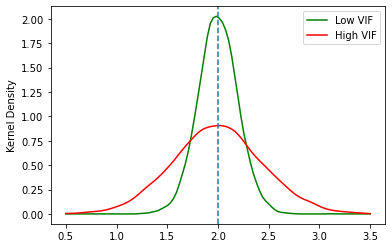

In [48]:
xx=np.linspace(0.5,3.5,num=100)  # 図を作成するために横軸の値を設定

# 多重共線性が弱いケース
kde_model_weak=gaussian_kde(b1hat_weak)  # OLS推定量のカーネル密度関数を計算

# 多重共線性が強いケース
kde_model_strong=gaussian_kde(b1hat_strong)

plt.plot(xx, kde_model_weak(xx), 'g-', label='Low VIF')  # OLS推定量の分布プロット
plt.plot(xx, kde_model_strong(xx),'r-', label='High VIF')  # IV推定量の分布プロット
plt.axvline(x=b1,linestyle='dashed')
plt.ylabel('Kernel Density')  # 縦軸のラベル
plt.legend()  # 凡例
pass

In [49]:
np.var(b1hat_weak), np.var(b1hat_strong)

(0.03880414913704464, 0.20072822946687585)

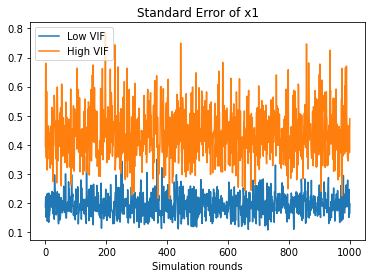

In [50]:
def sim_se(n, N, m, b0=1.0, b1=2.0, b2=3.0):  # n=標本の大きさ, N=標本数, m=共分散
    
    rv_mean = [4, 1]  # x1, x2の平均
    # x1, x2の共分散行列
    rv_cov = [[1.0, m],    # 全ての変数の分散は１（対角成分）
              [m, 1.0]]  # Cov(x1,x2)=m
    
    # 推定値を入れるarray
    se_x1_arr = np.zeros(N)
    se_x2_arr = np.zeros(N)

    for i in range(N):  # N 回のループ
        
        rv = multivariate_normal.rvs(rv_mean, rv_cov, size=n)  # x1, x2,をnセット抽出
        x1 = rv[:,0]  # 説明変数
        x2 = rv[:,1]  # 説明変数
        X = np.stack([np.ones(n),x1,x2],axis=1)  # 説明変数の行列    
        
        u = np.random.normal(loc=0, scale=1, size=n)  # 誤差項（標準正規分布）
        y = b0 + b1*x1 + b2*x2 + u  # 説明変数

        bhat = np.linalg.inv((X.T)@X)@(X.T)@y # 係数の推定値
        yhat = X@bhat  # yの予測値
        uhat = y-yhat  # 残差
        rss = (uhat.T)@uhat  # 残差平方和
        sigma2 = rss/(n-3)  # 回帰の残差（不偏）分散 
        XTX_1 = np.linalg.inv(X.T@X)  # moment matrix
        variance = sigma2*np.diag(XTX_1)  # bの分散
        se = np.sqrt(variance)  # bの標準誤差
        
        se_x1_arr[i] = se[1]  # arrayに追加
        se_x2_arr[i] = se[2]  # array追加
        
    return se_x1_arr, se_x2_arr # 返り値の設定


# 多重共線性が弱いケース 
se_x1_weak, se_x1_weak = sim_se(30,1000,m=0.1)

# 多重共線性が強いケース 
se_x1_strong, se_x1_strong = sim_se(30,1000,m=0.9)


plt.plot(se_x1_weak, label='Low VIF')
plt.plot(se_x1_strong, label='High VIF')
plt.title('Standard Error of x1')
plt.xlabel('Simulation rounds')
plt.legend()
pass

In [51]:
sum(se_x1_weak)/len(se_x1_weak), sum(se_x1_strong)/len(se_x1_strong)

# 次のコードでもOK
# np.array(se_x1_weak).mean(), np.array(se_x1_strong).mean()

(0.19302956245076403, 0.4404667554468392)

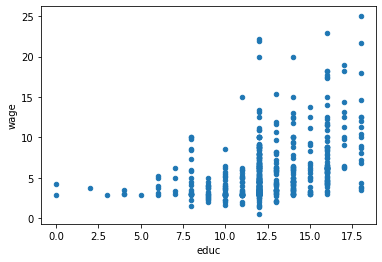

In [52]:
wage1.plot.scatter('educ','wage')
pass

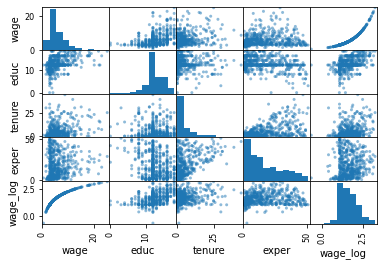

In [53]:
scatter_matrix(wage1)
pass

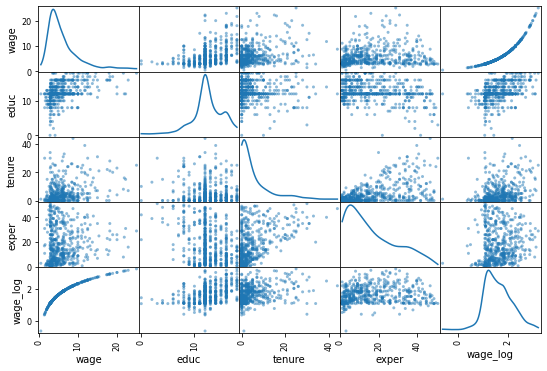

In [54]:
scatter_matrix(wage1, figsize=(9, 6), diagonal='kde')
pass

In [55]:
mat = wage1.corr()
mat

,wage,educ,tenure,exper,wage_log
wage,1.000000,0.405903,0.346890,0.112903,0.937062
educ,0.405903,1.000000,-0.056173,-0.299542,0.431053
tenure,0.346890,-0.056173,1.000000,0.499291,0.325538
exper,0.112903,-0.299542,0.499291,1.000000,0.111373
wage_log,0.937062,0.431053,0.325538,0.111373,1.000000


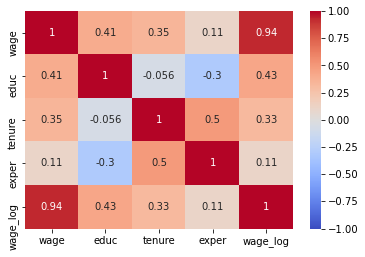

In [56]:
sns.heatmap(mat, vmin=-1, annot=True, cmap='coolwarm')
pass

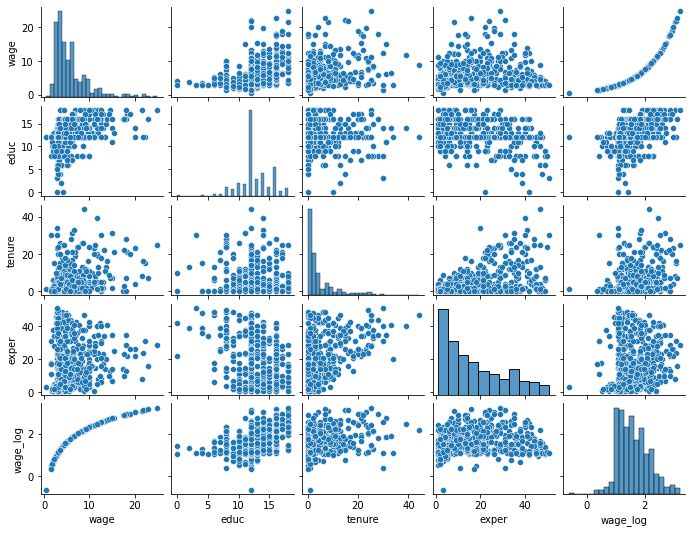

In [57]:
sns.pairplot(wage1, height=1.5, aspect=1.3)
pass